In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

In [31]:
csv = "/Users/dan/Documents/Finance/Programs/Financial Machine Learning/Backtesting/ES-Trades-During-Market-Hours.csv"
df = pd.read_csv(csv)

KeyboardInterrupt: 

In [35]:
df

,time,price,volume,symbol,date
0,1.702651e+09,4768.25,16.0,ESH4,2023-12-15
1,1.702651e+09,4768.25,3.0,ESH4,2023-12-15
2,1.702651e+09,4768.25,1.0,ESH4,2023-12-15
3,1.702651e+09,4768.25,2.0,ESH4,2023-12-15
4,1.702651e+09,4768.25,2.0,ESH4,2023-12-15
...,...,...,...,...,...
16381744,1.710448e+09,5154.25,1.0,ESH4,2024-03-14
16381745,1.710448e+09,5154.25,1.0,ESH4,2024-03-14
16381746,1.710448e+09,5154.25,3.0,ESH4,2024-03-14
16381747,1.710448e+09,5154.50,3.0,ESH4,2024-03-14


1. Verify that data has been sampled only during market hours by plotting time and observing a staircase

<Axes: >

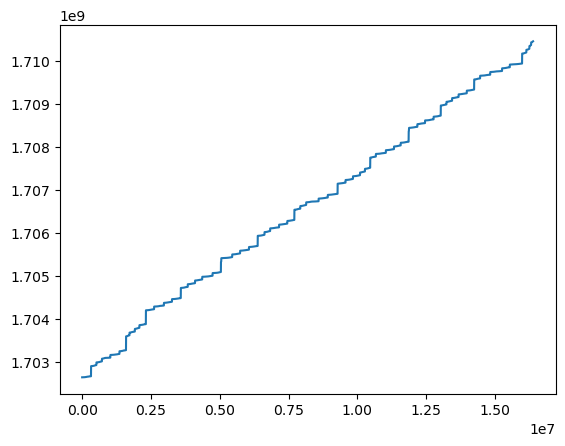

In [ ]:
df.time.plot()

See which symbols are present in the df, use just ES March 2024 to backtest.
In this case, it seems we already have only march 2024 contracts. (ESH4)

In [ ]:
df.symbol.unique() 

array(['ESH4'], dtype=object)

Find the start and end date. Observe that it starts 12/15/2023 9:30 am and ends 03/14/24 4:30pm

In [ ]:
datetime.fromtimestamp(df.time.min()).astimezone(pytz.timezone('US/Eastern')), datetime.fromtimestamp(df.time.max()).astimezone(pytz.timezone('US/Eastern'))

(datetime.datetime(2023, 12, 15, 9, 30, 0, 526, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>),
 datetime.datetime(2024, 3, 14, 16, 30, 55, 940902, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>))

Verify that the time column is sorted

In [ ]:
df.time.is_monotonic_increasing

True

Lastly, let's add a date column to easily identify date changes. 

In [ ]:
df['date'] = pd.to_datetime(df['time'], unit='s').dt.date

In [ ]:
df

,time,price,volume,symbol,date
0,1.702651e+09,4768.25,16.0,ESH4,2023-12-15
1,1.702651e+09,4768.25,3.0,ESH4,2023-12-15
2,1.702651e+09,4768.25,1.0,ESH4,2023-12-15
3,1.702651e+09,4768.25,2.0,ESH4,2023-12-15
4,1.702651e+09,4768.25,2.0,ESH4,2023-12-15
...,...,...,...,...,...
16381744,1.710448e+09,5154.25,1.0,ESH4,2024-03-14
16381745,1.710448e+09,5154.25,1.0,ESH4,2024-03-14
16381746,1.710448e+09,5154.25,3.0,ESH4,2024-03-14
16381747,1.710448e+09,5154.50,3.0,ESH4,2024-03-14


Defining the backtesting class.

In [ ]:
class Backtest():
    def __init__(self, df, time_increment):
        time_increment_precision = len(str(time_increment).split('.')[1])
        self.next_time = round(df.time[0], time_increment_precision)
        self.current_date = df.date[0]
        self.last_price = df.price[0]
        self.results = {}
        self.daily_trades = []
        self.df = df
        self.index = 0
        self.time_increment = time_increment

    def tickPrice(self):
        # if index points to a new date, we need to advance the time to the next trading day
        if self.df.date[self.index] != self.current_date:
            self.record_daily_trades()
            self.current_date = self.df.date[self.index]
            self.next_time = round(self.df.time[self.index], len(str(self.time_increment).split('.')[1]))

        # if index time is less than next time, return last price
        # otherwise, advance the index and update last price
        while self.df.time[self.index] <= self.next_time:
            self.last_price = self.df.price[self.index]
            self.index += 1
            if self.index >= len(self.df): return None
        
        # increment time on each tick to simulate sampling interval
        self.next_time += self.time_increment 
        return self.last_price
    
    def record_daily_trades(self):
        self.results[self.current_date] = self.daily_trades
        self.daily_trades = []


Observe the reduction in sampling rate by plotting the prices returned by the tick function vs the entire dataframe's prices

End of data
done


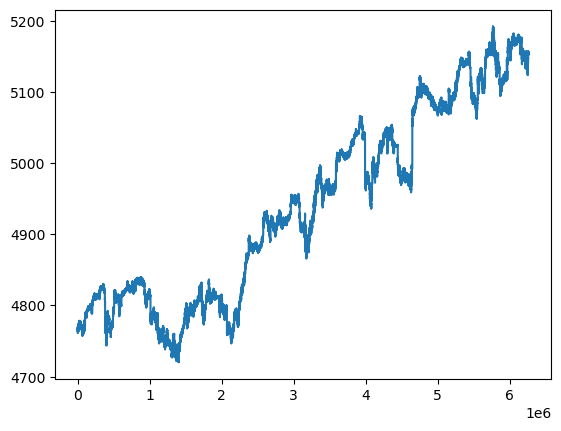

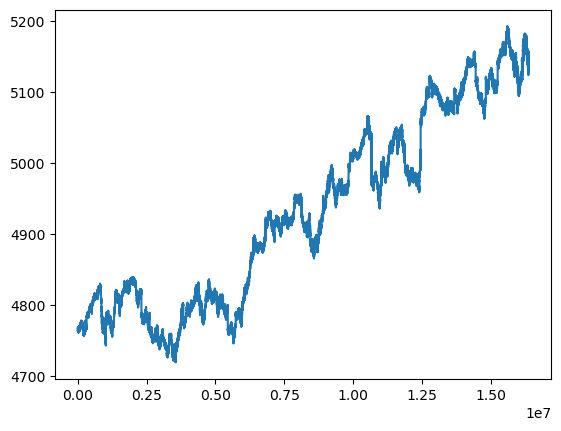

In [ ]:
bt = Backtest(df, 0.25)

prices = []
while True:
    price = bt.tickPrice()
    if price is None: 
        print('End of data')
        break
    prices.append(price)

print('done')
#2 minutes

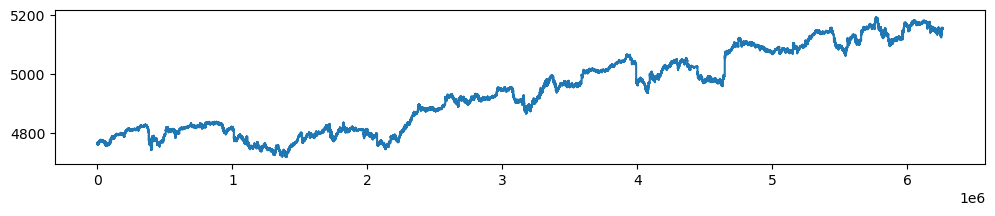

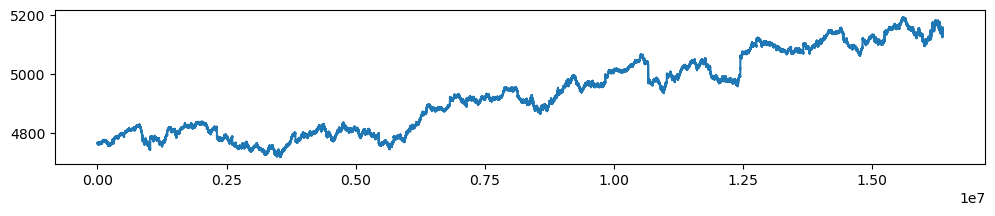

Sampling reduction factor: 2.62


In [ ]:
# and plot the prices and another plot of df.price[:bt.index]), 2 separate plots
fig, ax = plt.subplots(figsize=(12,2))
ax.plot(prices)
plt.show()

fig, ax = plt.subplots(figsize=(12,2))
ax.plot(df.price[:bt.index])
plt.show()

print(f"Sampling reduction factor: {bt.index / len(prices):.2f}")


It's time to start adding the trading specifics to the backtesting class. 

In [32]:
class Backtest:
    def __init__(self, df, time_increment):
        time_increment_precision = len(str(time_increment).split('.')[1])
        self.next_time = round(df.time[0], time_increment_precision)
        self.current_date = df.date[0]
        self.last_price = df.price[0]
        self.results = {}
        self.daily_trades = []
        self.df = df
        self.index = 0
        self.time_increment = time_increment

        # Trading logic variables
        self.qty = 0  # Position quantity: 1 for long, -1 for short, 0 for no position
        self.total_profit = 0  # To track the total profit made
        self.leverage = 50  # Example leverage for futures trading
        self.commission = 2.25  # Commission per contract per side
        self.tick_size = 0.25  # Fixed tick size for slippage

    def tickPrice(self):
        # if index points to a new date, we need to advance the time to the next trading day
        if self.df.date[self.index] != self.current_date:
            self.record_daily_trades()
            self.current_date = self.df.date[self.index]
            self.next_time = round(self.df.time[self.index], len(str(self.time_increment).split('.')[1]))

        # if index time is less than next time, return last price
        # otherwise, advance the index and update last price
        while self.df.time[self.index] <= self.next_time:
            self.last_price = self.df.price[self.index]
            self.index += 1
            if self.index >= len(self.df):
                return None
        
        # increment time on each tick to simulate sampling interval
        self.next_time += self.time_increment 
        return self.last_price
    
    def record_daily_trades(self):
        self.results[self.current_date] = self.daily_trades
        self.daily_trades = []

    def open_long_position(self):
        slip_price = self.last_price + self.tick_size  # Adjust for slippage
        self.qty = 1
        self.daily_trades.append({"action": "open", "side": "buy", "fillPrice": slip_price})
        # print(f"Opened long position at {slip_price:.2f}")

    def open_short_position(self):
        slip_price = self.last_price - self.tick_size  # Adjust for slippage
        self.qty = -1
        self.daily_trades.append({"action": "open", "side": "sell", "fillPrice": slip_price})
        # print(f"Opened short position at {slip_price:.2f}")

    def close_long_position(self):
        slip_price = self.last_price - self.tick_size  # Adjust for slippage
        self.daily_trades.append({"action": "close", "side": "sell", "fillPrice": slip_price})
        # print(f"Closed long position at {slip_price:.2f}")
        self.qty = 0

    def close_short_position(self):
        slip_price = self.last_price + self.tick_size  # Adjust for slippage
        self.daily_trades.append({"action": "close", "side": "buy", "fillPrice": slip_price})
        # print(f"Closed short position at {slip_price:.2f}")
        self.qty = 0

Now, let's bring in the mean reversion strategy. 

In [ ]:
"""
This was the code from the strategy.py file, but let's use ChatGPT's changes, as shown in the next cell, instead. 


from collections import deque

def mean_reversion(app, boll_window=600, rsi_window=200, width=2):
    prices = deque(maxlen=boll_window)
    def tick():
        app.tickPrice()
        prices.append(app.last_price)

        mu = np.mean(prices)
        std = np.std(prices)
        upper_band = mu + width * std
        lower_band = mu - width * std

        if app.qty != 0:
            app.open_time += 1

        if len(prices) == boll_window:
            if app.qty == 0:
                if app.last_price < lower_band:
                    app.open_long_position()
                elif app.last_price > upper_band:
                    app.open_short_position()
            elif app.qty == 1:
                if app.last_price >= mu:
                    app.close_long_position()
            elif app.qty == -1:
                if app.last_price <= mu:
                    app.close_short_position()
"""


In [33]:
from collections import deque
import numpy as np

class MeanReversionStrategy:
    def __init__(self, app, boll_window=600, rsi_window=200, width=2):
        self.app = app
        self.boll_window = boll_window
        self.rsi_window = rsi_window
        self.width = width
        self.prices = deque(maxlen=boll_window)
    
    def calculate_bands(self):
        mu = np.mean(self.prices)
        std = np.std(self.prices)
        upper_band = mu + self.width * std
        lower_band = mu - self.width * std
        return mu, upper_band, lower_band
    
    def tick(self):
        self.app.tickPrice()
        self.prices.append(self.app.last_price)
        
        if len(self.prices) == self.boll_window:
            mu, upper_band, lower_band = self.calculate_bands()
            
            if self.app.qty == 0:
                if self.app.last_price < lower_band:
                    self.app.open_long_position()
                elif self.app.last_price > upper_band:
                    self.app.open_short_position()
            elif self.app.qty == 1:
                if self.app.last_price >= mu:
                    self.app.close_long_position()
            elif self.app.qty == -1:
                if self.app.last_price <= mu:
                    self.app.close_short_position()



In [34]:
# Running the backtest
def run_backtest(app, strategy):
    while app.tickPrice() is not None:
        strategy.tick()

app = Backtest(df=df, time_increment=0.25)
strategy = MeanReversionStrategy(app)
run_backtest(app, strategy)

KeyboardInterrupt: 

Opened long position at 4763.75


AttributeError: 'Backtest' object has no attribute 'open_time'